## MY CNN model for Ucohead with the model tested 10-mokey-species

Test CNN model
as following the tutorial : https://www.tensorflow.org/tutorials/images/classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BATCH_SIZE = 32
# IMG_SIZE = (500,500)
# IMG_W = 500
# IMG_H = 500
IMG_SIZE = (40,40)
IMG_W = 40
IMG_H = 40
# IMG_SIZE = (200,200)
# IMG_W = 200
# IMG_H = 200

In [4]:
train_dataset = image_dataset_from_directory("../dataset/train/",
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 7818 files belonging to 10 classes.


In [5]:
validation_dataset = image_dataset_from_directory("../dataset/test/",
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)

Found 3806 files belonging to 10 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

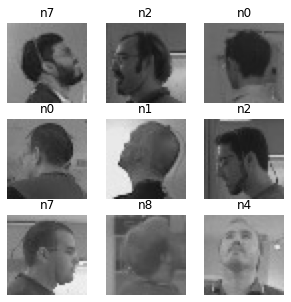

In [7]:
plt.figure(figsize=(5,5))
for images, labels in train_dataset.take(1):
    first_image=images[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 40, 40, 3)
(32,)


In [9]:
first_image.shape

TensorShape([40, 40, 3])

In [10]:
first_image

<tf.Tensor: shape=(40, 40, 3), dtype=float32, numpy=
array([[[164., 164., 164.],
        [163., 163., 163.],
        [157., 157., 157.],
        ...,
        [117., 117., 117.],
        [113., 113., 113.],
        [116., 116., 116.]],

       [[161., 161., 161.],
        [160., 160., 160.],
        [154., 154., 154.],
        ...,
        [117., 117., 117.],
        [115., 115., 115.],
        [118., 118., 118.]],

       [[158., 158., 158.],
        [157., 157., 157.],
        [153., 153., 153.],
        ...,
        [116., 116., 116.],
        [117., 117., 117.],
        [118., 118., 118.]],

       ...,

       [[134., 134., 134.],
        [135., 135., 135.],
        [136., 136., 136.],
        ...,
        [135., 135., 135.],
        [196., 196., 196.],
        [146., 146., 146.]],

       [[133., 133., 133.],
        [134., 134., 134.],
        [135., 135., 135.],
        ...,
        [148., 148., 148.],
        [200., 200., 200.],
        [166., 166., 166.]],

       [[133., 133.

In [14]:
# AUTOTUNE =tf.data.experimental.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

AUTOTUNE =tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
from tensorflow.keras import layers

In [16]:
data_augmentation = keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_H, IMG_W, 3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1, input_shape=(IMG_H, IMG_W, 3)),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
#     layers.experimental.preprocessing.RandomCrop(32,32)
])

#### Standardize the data

The RGB channel values are in the ```[0, 255]``` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the ```[0,1]``` range by using a Rescaling layer.

In [17]:
normalized_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [19]:
# Don't know why but sequential model only works...

num_classes = 10
model = Sequential([
#     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_H, IMG_W, 3)),
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = "same", activation ="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding = "same", activation ="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding = "same", activation ="relu"),
    layers.Dropout(0.2),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

In [20]:
# #### Ucohead original


# def my_model(input_shape, drop_rate): # dr0.2/
#     model = Sequential([
#         Conv2D(filters=32, input_shape=input_shape, kernel_size=(3,3), strides=2, activation = 'relu'),
#         Dropout(drop_rate),
#         Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#         Dropout(drop_rate),
#         Dense(units=32, activation='relu')
# #         Dense(units=1, activation='softmax')
#     ])
#     return model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
early_stopping=EarlyStopping(monitor="val_loss", patience=30, verbose=2)

In [23]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 40, 40, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)       

In [25]:
epochs=200
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping])

Epoch 1/200
245/245 [==============================] - 10s 41ms/step - loss: 2.1655 - accuracy: 0.1741 - val_loss: 1.6798 - val_accuracy: 0.3702
Epoch 2/200
245/245 [==============================] - 1s 6ms/step - loss: 1.6933 - accuracy: 0.3477 - val_loss: 1.2533 - val_accuracy: 0.5113
Epoch 3/200
245/245 [==============================] - 1s 6ms/step - loss: 1.4376 - accuracy: 0.4427 - val_loss: 1.0805 - val_accuracy: 0.5846
Epoch 4/200
245/245 [==============================] - 1s 6ms/step - loss: 1.2721 - accuracy: 0.4973 - val_loss: 0.9804 - val_accuracy: 0.6206
Epoch 5/200
245/245 [==============================] - 1s 6ms/step - loss: 1.1717 - accuracy: 0.5342 - val_loss: 0.9047 - val_accuracy: 0.6445
Epoch 6/200
245/245 [==============================] - 1s 6ms/step - loss: 1.0958 - accuracy: 0.5687 - val_loss: 0.8472 - val_accuracy: 0.6668
Epoch 7/200
245/245 [==============================] - 1s 6ms/step - loss: 1.0464 - accuracy: 0.5872 - val_loss: 0.7628 - val_accuracy: 0.69

Epoch 58/200
245/245 [==============================] - 1s 6ms/step - loss: 0.4597 - accuracy: 0.8143 - val_loss: 0.3356 - val_accuracy: 0.8644
Epoch 59/200
245/245 [==============================] - 1s 6ms/step - loss: 0.4612 - accuracy: 0.8109 - val_loss: 0.3496 - val_accuracy: 0.8568
Epoch 60/200
245/245 [==============================] - 1s 6ms/step - loss: 0.4513 - accuracy: 0.8180 - val_loss: 0.3291 - val_accuracy: 0.8663
Epoch 61/200
245/245 [==============================] - 1s 6ms/step - loss: 0.4591 - accuracy: 0.8181 - val_loss: 0.3130 - val_accuracy: 0.8734
Epoch 62/200
245/245 [==============================] - 1s 6ms/step - loss: 0.4571 - accuracy: 0.8148 - val_loss: 0.3702 - val_accuracy: 0.8502
Epoch 63/200
245/245 [==============================] - 1s 6ms/step - loss: 0.4563 - accuracy: 0.8167 - val_loss: 0.3284 - val_accuracy: 0.8744
Epoch 64/200
245/245 [==============================] - 1s 6ms/step - loss: 0.4493 - accuracy: 0.8194 - val_loss: 0.3313 - val_accuracy:

Epoch 115/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3689 - accuracy: 0.8543 - val_loss: 0.3118 - val_accuracy: 0.8744
Epoch 116/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3675 - accuracy: 0.8547 - val_loss: 0.2914 - val_accuracy: 0.8841
Epoch 117/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3746 - accuracy: 0.8474 - val_loss: 0.2598 - val_accuracy: 0.8954
Epoch 118/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3760 - accuracy: 0.8475 - val_loss: 0.2791 - val_accuracy: 0.8889
Epoch 119/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3769 - accuracy: 0.8484 - val_loss: 0.2752 - val_accuracy: 0.8873
Epoch 120/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3790 - accuracy: 0.8468 - val_loss: 0.2818 - val_accuracy: 0.8886
Epoch 121/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3666 - accuracy: 0.8556 - val_loss: 0.2968 - val_ac

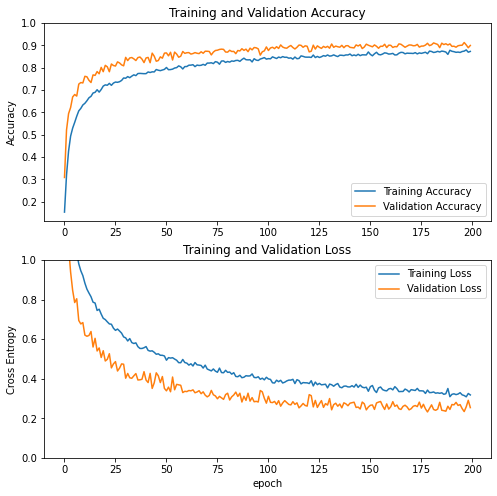

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [61]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
image_batch, label_batch 

(array([[[[138., 138., 138.],
          [129., 129., 129.],
          [115., 115., 115.],
          ...,
          [111., 111., 111.],
          [121., 121., 121.],
          [107., 107., 107.]],
 
         [[134., 134., 134.],
          [134., 134., 134.],
          [115., 115., 115.],
          ...,
          [111., 111., 111.],
          [118., 118., 118.],
          [105., 105., 105.]],
 
         [[125., 125., 125.],
          [123., 123., 123.],
          [102., 102., 102.],
          ...,
          [108., 108., 108.],
          [110., 110., 110.],
          [ 97.,  97.,  97.]],
 
         ...,
 
         [[121., 121., 121.],
          [118., 118., 118.],
          [111., 111., 111.],
          ...,
          [ 70.,  70.,  70.],
          [ 78.,  78.,  78.],
          [ 82.,  82.,  82.]],
 
         [[121., 121., 121.],
          [119., 119., 119.],
          [112., 112., 112.],
          ...,
          [ 65.,  65.,  65.],
          [ 71.,  71.,  71.],
          [ 77.,  77.,  77.

In [58]:
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)
# predictions = tf.max(predictions)
prediction = tf.reduce_max(prediction)
prediction

<tf.Tensor: shape=(), dtype=float32, numpy=3.0850663>

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
prediction = tf.reduce_max(prediction, axis=1)


print('Predictions:\n', predictions.numpy())
# print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Predictions:
 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
Labels:
 [6 5 5 6 5 0 1 1 1 1 6 6 2 4 1 2 9 4 1 9 8 5 9 6 1 5 2 1 2 1 1 7]


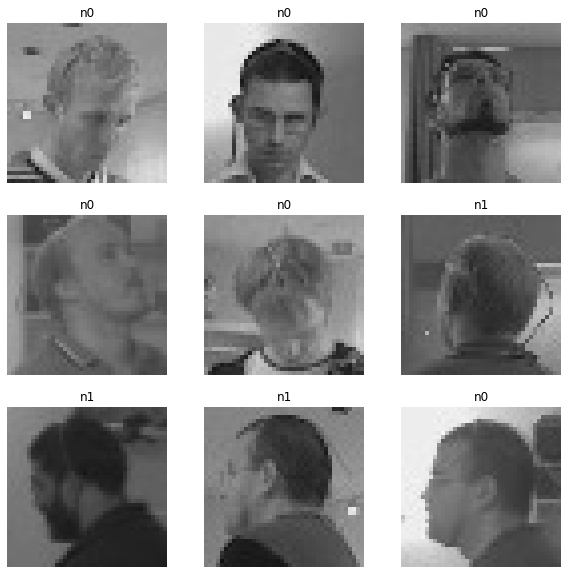

In [51]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)
predictions = tf.where(predictions < 0.9, 0, 1)

print('Predictions:\n', predictions.numpy())
# print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [49]:
# inputs = tf.keras.Input(shape=(IMG_W, IMG_H, 3))
# # x = data_augmentation(inputs)
# x = inputs
# # x = rescale(x)
# x = model(x)
# outputs = prediction_layer(x)
# cnn_model = tf.keras.Model(inputs, outputs)

In [50]:
# new_img_path = "../large.jpg"

new_img_path ="../side_view.jpg"

new_img = keras.preprocessing.image.load_img(new_img_path, target_size=(IMG_H, IMG_W, 3))
img_array = keras.preprocessing.image.img_to_array(new_img)
img_array = tf.expand_dims(img_array, 0) # create a batch

prediction = model.predict(img_array)
score = tf.nn.softmax(prediction[0])

print("This image most likely belongs to {} with {:.2f} percent confidence.". format(class_names[np.argmax(score)], 100*np.max(score)))

This image most likely belongs to n4 with 89.86 percent confidence.


In [58]:
# base_lr = 0.0001
# cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr), 
# #                   loss = tf.keras.losses.categorical_crossentropy(from_logits=True),
#                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])

In [59]:
# from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# class TrainingCallback(Callback):
#     def on_train_begin(self, logs=None):
#         print("Starting training ...")
#     def on_train_end(self, logs=None):
#         print("Finished training!")

# early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

In [60]:
# initial_epochs = 200
# loss0, accuracy0 = cnn_model.evaluate(validation_dataset)

In [61]:
# print("initial loss : {:.2f}".format(loss0))
# print("initial accuracy : {:.2f}".format(accuracy0))

In [62]:
# # history = cnn_model.fit(train_dataset,
# #                        epochs=initial_epochs,
# #                        validation_data=validation_dataset,
# #                        callbacks=[TrainingCallback(), early_stopping])
# history = cnn_model.fit(train_dataset,
#                        epochs=initial_epochs,
#                        validation_data=validation_dataset,
#                        callbacks=[TrainingCallback()])

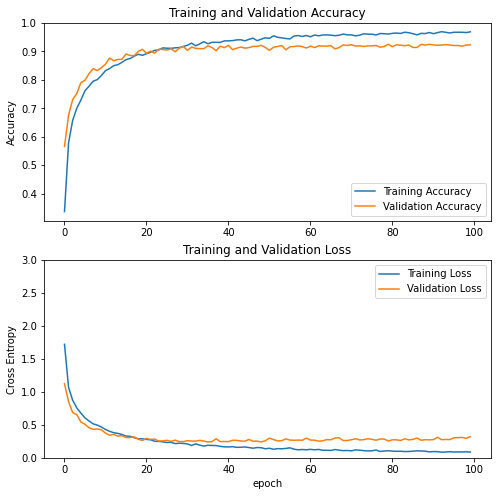

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [334]:
# import pickle
# with open("./cnn_model_test00",'wb') as file_pi:
#     pickle.dump(history_fine.history, file_pi)

In [335]:
# test_load = pickle.load(open("./cnn_model_test00",'rb'))
# test_load['loss']

In [33]:
total_image_num = 32
random_inx = np.random.choice(total_image_num, 9) 

predictions = model.predict()

plt.figure(figsize=(5,5))
for images, labels in validation_dataset.take(1):
    random_image=images[random_inx]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] + class_names[predictions[i]])
        plt.axis("off")

<TakeDataset shapes: ((None, 40, 40, 3), (None,)), types: (tf.float32, tf.int32)>